In [ ]:
!source activate tensorflow

In [3]:
!mkdir checkpoint

In [2]:
!ls data/train2014/ | wc 

   2105    2105   67360


In [1]:
# make data smaller
import os
import random
from glob import glob

for filename in glob('data/train2014/*'):
    if random.random() > 0.025: # use only 2.5% of the data
        os.remove(filename)

In [ ]:
# learn art style: train model
# upload steampunk image
!time python style.py --style ../steampunk.jpg --checkpoint-dir checkpoint --epochs 2 --checkpoint-iterations 10 --batch-size 16
#!nvidia-smi # read "Disp.A Memory-Usage: and "GPU Memory Usage" for how much GPU RAM usage; "Volatile GPU-Util" grossly inaccurate
!pip install glances # glances is way better than nvidia-smi in terms of accuracy and UI
!pip install nvidia-ml-py3
!glances
# remove test-dir and other parameters for now

# use small batches if training pictures are bigger



# on 2.5% of pictures and 16 minibatch:
# real    9m59.879s
# user    9m5.264s
# sys     0m48.336s

In [ ]:
# original
!mkdir test_dir
!time python style.py --style ../cross_style.jpg --checkpoint-dir checkpoint --epochs 10 --checkpoint-iterations 100 --batch-size 16 --test ../seagull_on_sidewalk_small.jpg --test-dir test_dir

#### retry

## appears that it will regress to black; maybe GPU RAM constrained?
## also uses CPU by default, I changed it to be GPU, don't know if RAM is constrained. Have to make this argparse
## every iteration causes checkpoint save (GPU not running) and inference on test image, so use high iteration number

# real    56m18.865s
# user    50m23.584s
# sys     4m13.656s

In [ ]:
# content weight doubled
!mkdir test_dir_content_weight_modified/
!time python style.py --style ../cross_style.jpg --checkpoint-dir checkpoint --epochs 10 --checkpoint-iterations 100 --batch-size 16 --test ../seagull_on_sidewalk_small.jpg --test-dir test_dir_content_weight_modified/ --content-weight 1.5e1

## appears that it will regress to black; maybe GPU RAM constrained?
## also uses CPU by default, I changed it to be GPU, don't know if RAM is constrained. Have to make this argparse
## every iteration causes checkpoint save (GPU not running) and inference on test image, so use high iteration number

# runtime was just an extra 20 seconds

In [ ]:
# learning rate x 10
!mkdir test_dir_lr_modified_x10
!time python style.py --style ../cross_style.jpg --checkpoint-dir checkpoint --epochs 10 \
    --checkpoint-iterations 100 --batch-size 16 --test ../seagull_on_sidewalk_small.jpg \
    --test-dir test_dir_lr_modified_x10/ --learning-rate 1e-2 &> test_dir_lr_modified_x10/runtime_lr_x10.txt

## appears that it will regress to black (False); maybe GPU RAM constrained? (False)
## also uses CPU by default, I changed it to be GPU, don't know if RAM is constrained. Have to make this argparse
## every iteration causes checkpoint save (GPU not running) and inference on test image, so use high iteration number

# real    56m19.089s
# user    50m22.908s
# sys     4m17.932s

In [ ]:
# learning rate x 5
!mkdir test_dir_lr_modified_x5
!time python style.py --style ../cross_style.jpg --checkpoint-dir checkpoint --epochs 10 \
    --checkpoint-iterations 100 --batch-size 16 --test ../seagull_on_sidewalk_small.jpg \
    --test-dir test_dir_lr_modified --learning-rate 5e-3 &> test_dir_lr_modified_x5/runtime_lr_x5.txt
    
## appears that it will regress to black; maybe GPU RAM constrained?
## also uses CPU by default, I changed it to be GPU, don't know if RAM is constrained. Have to make this argparse
## every iteration causes checkpoint save (GPU not running) and inference on test image, so use high iteration number

# real    45m48.311s
# user    42m41.188s
# sys     3m3.264s

# Learning rate still too high
# estimate 6 seconds per checkpoint save and evaluate. ~23% runtime just on this step
# possible to isolate time cost by simply not evaluating and checkpointing

In [1]:
# replicating results
!mkdir test_dir_replicate
!time python style.py --style examples/style/rain_princess.jpg  \
    --checkpoint-dir checkpoint --checkpoint-iterations 50 --batch-size 16 --train-path data/train2014_large \
    --test examples/content/chicago.jpg --test-dir test_dir_replicate \
    &> test_dir_replicate/runtime_replicate.txt

    
# my batch size is smaller, so more iterations
# checkpoint at every 50 iterations
# kept default content weight, not the one specified in the bash command

In [ ]:
# replicating results -- should be identical except checkpoint iterations
!mkdir test_dir_replicate
!time python style.py --style examples/style/rain_princess.jpg --content-weight 1.5e1 \
    --checkpoint-dir checkpoint --checkpoint-iterations 50 --batch-size 20 --train-path data/train2014_large \
    --test examples/content/chicago.jpg --test-dir test_dir_replicate \
    &> test_dir_replicate/runtime_replicate.txt

    
# batch size is 20, fewer iterations than if batch size were 16
# checkpoint at every 50 iterations
# used content_weight from bash, not default content weight

In [ ]:
# apply style on another picture, compare CPU vs GPU
# I don't think there are any other important parameters
!time python evaluate.py --checkpoint checkpoint --in-path examples/style/rain_princess.jpg --out-path ../output_image.jpg

# about the same between GPU (slightly faster) and CPU
# real    0m5.287s
# user    0m3.556s
# sys     0m2.068s

In [ ]:
# apply style to video
# upload video: play_dead.mp4
# use smaller minibatch if video very high resolution
!time python transform_video.py --in-path ../play_dead.mp4   --checkpoint checkpoint   --out-path ../output_video.mp4   --device /gpu:0   --batch-size 16

# GPU
# real    0m19.682s
# user    0m22.548s
# sys     0m6.408s

# CPU
# real    5m50.725s
# user    21m21.868s
# sys     1m17.100s

In [3]:
# add the first part to GPU to reduce runtime by 22 seconds

# Speed
## Try: more GPUs
## Done: bigger minibatch, less pictures

# Quality: figure out the parameters such that improvement plateaus
## Try: increase style weight, increase learning rate
## Done: add test folder, increase content weight makes fewer iterations to get original picture back

# Notes:
## notice with more iterations, then color of original image more visible; I assume that means the content loss is being reduced
## GPU RAM is full on this EC2 instance by loading up model. Thank goodness it fits into memory! For more powerful GPU, can probably increase minibatch for evaluation
## Currently GPU RAM constrained; not sure how it's evaluating testing picture without sufficient GPU RAM

In [ ]:
--style, --checkpoint-dir # explicitly required
--train-path, --vgg-path # implicitly required

--epochs, --checkpoint-iterations, --batch-size, # optional
--test, --test-dir, --content-weight, --style-weight, --tv-weight, --learning-rate # more optional

In [ ]:
real    763m46.949s
user    1192m59.980s
sys     74m2.732s

# Plotting

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from collections import OrderedDict

def get_structured_data(data):
    key_value_tups = (OrderedDict(element.split(' = ') for element in line.split('; ')) for line in data)
    return pd.DataFrame(key_value_tups)

with open('test_dir_replicate/runtime_replicate.txt') as f: ## hard coded file name
    data = f.read().splitlines()
    useful_data = [line for line in data if 'Current Time' in line]
    structured_data = get_structured_data(useful_data)
    structured_data[['Epoch', 'Iteration']] = structured_data[['Epoch', 'Iteration']].astype('int')
    structured_data[['Loss', 'Time Elapsed']] = structured_data[['Loss', 'Time Elapsed']].astype('float32')
    structured_data.set_index(structured_data.index * 50, inplace=True) ### hard coded to 50 iterations

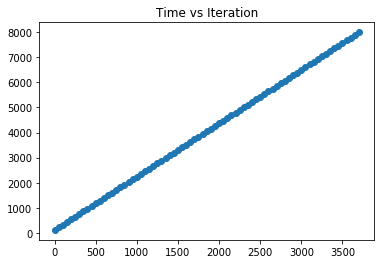

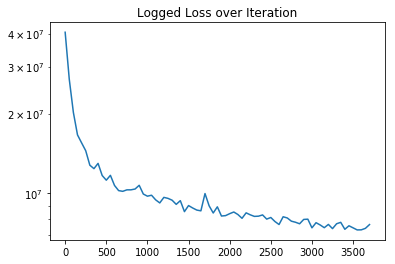

In [2]:
structured_data['Time Elapsed'].cumsum().plot(title="Time vs Iteration", marker='o', linestyle='None')
plt.show()
structured_data['Loss'].plot(logy=True, title='Logged Loss over Iteration')
plt.show()

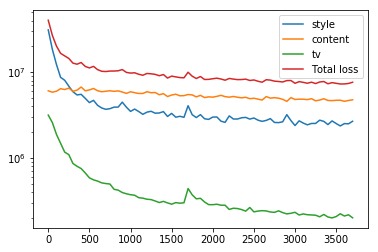

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from collections import OrderedDict


with open('test_dir_replicate/runtime_replicate.txt') as f: ## hard coded file name
    data = f.read().splitlines()
    useful_lines = [line for line in data if "Loss values" in line]
    key_value_tups = (OrderedDict(element.split(' = ') for element in line.replace("Loss values: ", "").split('; '))
                      for line in useful_lines)
    structured_data_loss = pd.DataFrame(key_value_tups).astype('float')
    structured_data_loss.set_index(structured_data_loss.index * 50, inplace=True) ### hard coded to 50 iterations

structured_data_loss.plot(logy=True)
structured_data_loss.sum(axis=1).plot(logy=True, label='Total loss')
plt.legend()

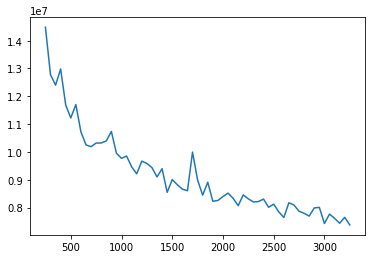

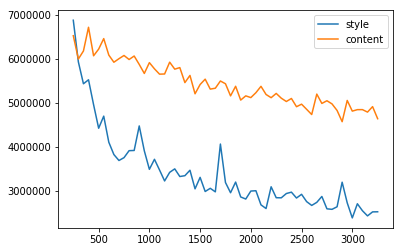

In [4]:
structured_data['Loss'][5:].plot()
plt.show()

structured_data_loss['style'][5:].plot()
structured_data_loss['content'][5:].plot()
plt.legend()
plt.show()

In [8]:
%%time
import imageio
from datetime import datetime, timedelta

seconds_between_frames = 30 # represents seconds of time for training
max_length_in_seconds = 60 * 60 * 2 ## hard coded to represent maximum length of training time
test_dirname = 'test_dir_replicate/' ### hard coded

image_filenames = []
next_frame_timestamp = None
for row_id, row in structured_data.iterrows():
    if row_id == 0:
        start_time = (datetime.strptime(row['Current Time'], "%Y %B %d, %H:%M:%S") -
                      timedelta(seconds=int(row['Time Elapsed'])))
        next_frame_timestamp = start_time
        while next_frame_timestamp < datetime.strptime(row['Current Time'], "%Y %B %d, %H:%M:%S"):
            image_filenames.append("{}{}_{}.png".format(test_dirname, row['Epoch'], row['Iteration']))
            next_frame_timestamp += timedelta(seconds=seconds_between_frames)
            
    else:
        while next_frame_timestamp < datetime.strptime(row['Current Time'], "%Y %B %d, %H:%M:%S"):
            image_filenames.append("{}{}_{}.png".format(test_dirname, row['Epoch'], row['Iteration']))
            next_frame_timestamp += timedelta(seconds=seconds_between_frames)        
        
image_sequence = []
for filename in image_filenames[:max_length_in_seconds // seconds_between_frames]:
    image_sequence.append(imageio.imread(filename))
imageio.mimsave('test_dir_replicate/movie.mp4', image_sequence, fps=24) ### fps hard coded

"""
import imageio

sorted_frame_names = 'test_dir_replicate/' + structured_data.apply(
    lambda row: "{}_{}.png".format(row['Epoch'], row['Iteration']), axis=1) # test_dir hard coded
images = []
for filename in sorted_frame_names:
    images.append(imageio.imread(filename))
imageio.mimsave('test_dir_replicate/movie.mp4', images, fps=2) ### fps hard coded
""";

CPU times: user 4.15 s, sys: 244 ms, total: 4.4 s
Wall time: 8.45 s


In [ ]:
# notes:
4 CPUs at full power vs 1 Tesla k80 (RAM: 12 GB; Compute Capability: 3.7)
714 second/iter vs 26 sec/iter   where iter is really 10 iters
hatching pattern means still bad, need more iterations to reduce hatching size until it disappears
    is hatching an artifact of style image or is it a measure of underfit?
takes 1 full epoch for style transfer to be good (5173 iterations); 
    at 1 epoch 3000 iterations, it probably jumped out local min (however, that's strange because 
    I think it's using consistent learning rate and not Adam [look at optimizer], so never supposed
    to do work)

p3 RAM 16 GB; Compute Capability 7.0 -- ~8 sec/iter (386 sec/iter on CPU cuz 8 CPUs)
bullion would have substantially more CPUs and more powerful GPU with more RAM, CC 6.0?
bullion has a premium GPU. Smaller GPUs like for gaming and bitcoin mining are not large enough to load in a GPU RAM.
Our model requires 9 GB of GPU RAM. 

taskset -p CPU_id PID # constrain process to specific CPU

the reason that things are faster is 2 parts: a) persistent GPU RAM which uses more than CPU RAM 
    (which probably gets garbaged collected) which uses only around 6 GB RAM
    b) lots more cores in GPU

In [ ]:
increase interation count per checkpoint
try to train with given style and given content (they use full dataset)
use p3 instance to train rapidly; use p2.8x to do simultaneous model (probably requires code change)
write script to detect new model and rename it to keep it from being overwritten

In [ ]:
pip install tensorflow
upload all the images
make checkpoint and test_dir 
made small change to the code

In [ ]:
!wget https://s3.amazonaws.com/style-transfer-installation/Installing_TensorFlow_with_CUDA.sh
!time bash Installing_TensorFlow_with_CUDA.sh

# delete ffmpeg installation: conda install -y ffmpeg -c conda-forge